Revert Classification - Demo
===

Building a classifier to predict reverts and produce calibrated propensity scores for being reverted.

This notebook is a pared-down demo notebook created for Solvejg.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [4]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
import sklearn.calibration

In [5]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join('/export/scratch2/levon003/repos/wiki-ores-feedback', "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [6]:
stub_history_dir = os.path.join(derived_data_dir, 'stub-history-all-revisions')
stub_history_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions'

In [7]:
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
working_dir = os.path.join(derived_data_dir, 'audit')
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit'

### Data loading and cleaning

In [8]:
# read in the sample dataframe
s = datetime.now()
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample3_filepath = os.path.join(revision_sample_dir, 'sample3_all.pkl')
rev_df = pd.read_pickle(sample3_filepath)
print(f"Sample 3 data loaded in {datetime.now() - s}.")
len(rev_df)

Sample 3 data loaded in 0:00:52.243535.


33964442

In [9]:
rev_df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting,is_sample_eligible,prev_rev_id,next_rev_id,prev_rev_timestamp,next_rev_timestamp,reverted_rev_ids,reverting_rev_id,reverting_rev_timestamp
1,12,818613649,1515102279,0,0,0,True,818611292,818624114,1515101356,1515106953,[],-1,-1
2,12,818624114,1515106953,1,0,0,True,818613649,820024812,1515102279,1515798752,[],-1,-1
3,12,820024812,1515798752,0,1,0,True,818624114,820025687,1515106953,1515799060,[],820025687,1515799060
4,12,820025687,1515799060,0,0,1,True,820024812,820703495,1515798752,1516095884,[820024812],-1,-1
5,12,820703495,1516095884,0,0,0,True,820025687,821673418,1515799060,1516597634,[],-1,-1


In [10]:
# Load the features
s = datetime.now()
labeled_revs_dir = os.path.join(derived_data_dir, 'labeled-revs')
sample3_features_dir = os.path.join(labeled_revs_dir, 'sample3-features')
sample3_damaging_filepath = os.path.join(sample3_features_dir, 'sample3.damaging.2020-07-11T15:11:15Z.tsv')
features_df = pd.read_csv(sample3_damaging_filepath, sep='\t', header=0)
print(f"Features data loaded in {datetime.now() - s}.")
len(features_df)

Features data loaded in 0:02:10.167396.


4005652

In [11]:
# drop the useless 'damaging' column (it is auto-generated)
features_df = features_df.drop(columns='damaging')

In [12]:
# load in the rev_ids that correspond to the feature data
# this is really slow, because it requires JSON decoding
# this could be made faster by caching the result
cache_filepath = os.path.join(labeled_revs_dir, 'sample3-features', 'sample3.mock.w_cache.2020-07-11T15:11:15Z.json')
cache_rev_id_list = []
with open(cache_filepath, 'r') as infile:
    for line in tqdm(infile, total=len(features_df)):
        rev = json.loads(line)
        rev_id = rev['rev_id']
        cache_rev_id_list.append(rev_id)

100%|██████████| 4005652/4005652 [03:34<00:00, 18674.65it/s]


In [13]:
assert len(cache_rev_id_list) == len(features_df)

In [14]:
cache_rev_id_set = set(cache_rev_id_list)
len(cache_rev_id_set)

4005602

In [15]:
# use use the last revision in this same to figure out when the analysis end time should be
last_rev = cache_rev_id_list[-1]
last_rev

826425205

In [16]:
# every rev_id in the cache should ALSO be in the rev_df
assert len(cache_rev_id_set & set(rev_df.rev_id)) == len(cache_rev_id_set), len(cache_rev_id_set & set(rev_df.rev_id))

In [17]:
# set the analysis start time to be the beginning of 2018
analysis_start_date = datetime.fromisoformat('2018-01-01')
analysis_start_date = analysis_start_date.replace(tzinfo=timezone.utc)
analysis_start_timestamp = int(analysis_start_date.timestamp())
print(f"Starting analysis from {datetime.utcfromtimestamp(analysis_start_timestamp)}")

Starting analysis from 2018-01-01 00:00:00


In [18]:
# note that this is less than 2 months of data right now!
# we have 20-25 million downloaded, but this 4 million set should be enough to get going
analysis_end_timestamp = rev_df[rev_df.rev_id == last_rev].rev_timestamp.iloc[0]
print(f"Using revisions up to {datetime.utcfromtimestamp(analysis_end_timestamp)}")

Using revisions up to 2018-02-19 07:18:15


In [19]:
# mostly to save memory, we trim out unneeded data in the rev_df
rev_df = rev_df[(rev_df.rev_timestamp <= analysis_end_timestamp)&(rev_df.rev_timestamp >= analysis_start_timestamp)]
len(rev_df)

4025634

In [20]:
# Read the revert info
# This dataframe contains additional data beyond what is in the rev_df
s = datetime.now()
stub_history_reverts_dir = os.path.join(derived_data_dir, 'stub-history-reverts')
revert_df_filepath = os.path.join(stub_history_reverts_dir, 'revert_df.pkl')
revert_df = pd.read_pickle(revert_df_filepath)
print(f"Loaded revert data in {datetime.now() - s}.")
len(revert_df)

Loaded revert data in 0:01:08.067346.


5992682

The most important info in the `revert_df` that isn't in the `rev_df` is the username info, which enables the identification of self-reverts.

`revert_df` has one line per **revert** revision, compared to the `rev_df` which has one line per revision.

In [21]:
revert_df.head()

,page_id,reverted_count,reverting_rev_id,reverting_timestamp,reverting_user_text,reverting_user_id,reverted_to_rev_id,reverted_to_timestamp,reverted_to_user_text,reverted_to_user_id,reverted_rev_ids,reverted_timestamps,reverted_user_texts,reverted_user_ids,reverting_user_is_anonymous,reverted_to_user_is_anonymous,reverted_users_is_anonymous
0,18754764,1,902766646,1561105801,Malcolmxl5,4076676.0,874884880,1545481829,Hmains,508734.0,[900328973],[1559706521],[2601:199:417F:8EED:A0B0:A6B5:3457:A9B4],[None],False,False,[True]
1,18754831,2,818980415,1515284429,BrownHairedGirl,754619.0,743241620,1475970276,Emir of Wikipedia,28856560.0,"[757539852, 775847398]","[1483188655, 1492452285]","[Ser Amantio di Nicolao, Emir of Wikipedia]","[753665, 28856560]",False,False,"[False, False]"
2,18754831,1,932235094,1577204938,UA3,25923702.0,918313790,1569654385,Monkbot,20483999.0,[932233860],[1577204033],[Qowa],[37692801],False,False,[False]
3,18754864,1,853153047,1533256539,Beetstra,855858.0,831996274,1521801439,KolbertBot,31691822.0,[846149041],[1529188413],[Lepidoptera~plwiki],[24892933],False,False,[False]
4,18754916,1,882182106,1549557841,Number 57,327289.0,847748130,1530126769,CitationCleanerBot,15270283.0,[882125775],[1549520001],[Huldra],[410653],False,False,[False]


In [22]:
# identify self-reverts
is_self_revert_list = []
for row in tqdm(revert_df.itertuples(), total=len(revert_df)):
    is_self_revert = row.reverting_user_text in row.reverted_user_texts
    is_self_revert_list.append(is_self_revert)
revert_df['is_self_revert'] = is_self_revert_list

100%|██████████| 5992682/5992682 [00:20<00:00, 292460.22it/s]


In [23]:
# only keep reverts that appear in the (filtered) rev_df
analysis_rev_ids = set(rev_df.rev_id)
revert_subset = revert_df[revert_df.reverting_rev_id.isin(analysis_rev_ids)].copy()
len(revert_subset), len(revert_subset) / len(revert_df)

(427375, 0.07131614859590414)

In [24]:
# now compute the outcome, which is a variant of `rev_df.is_reverted`
reverted_rev_ids = set()
# only count it as a reverted revision if it was not a self-revert
# and it was reverted within one week
threshold = 60 * 60 * 24 * 7 
rs = revert_subset[~revert_subset.is_self_revert]
for row in tqdm(rs.itertuples(), total=len(rs)):
    reverting_timestamp = row.reverting_timestamp
    for rev_id, timestamp in zip(row.reverted_rev_ids, row.reverted_timestamps):
        if reverting_timestamp - timestamp <= threshold:
            reverted_rev_ids.add(rev_id)
len(reverted_rev_ids)

100%|██████████| 377374/377374 [00:02<00:00, 178143.07it/s]


501159

In [25]:
# just for fun, we'll compare how the revised revert outcome we computed in the cell above compares to 
# the broader definition of reverting
rev_df['is_reverted_for_damage'] = rev_df.rev_id.map(lambda rev_id: rev_id in reverted_rev_ids)

In [26]:
# our revised revert measure trims off 84251 of 499347 (16.9%) of the total reverts
# as expected, all revisions with is_reverted == 0 also have is_reverted_for_damage == 1
pd.crosstab(rev_df.is_reverted, rev_df.is_reverted_for_damage, margins=True)

is_reverted_for_damage,False,True,All
is_reverted,,,
0,3526287,0,3526287
1,84251,415096,499347
All,3610538,415096,4025634


In [27]:
84251 / 499347

0.16872235139091654

#### Create the actual outcome variable and add it to the features dataframe

`features_df` contains only the features, not the revision ids. We create a binary outcome column based on the order of the revisions as they were read from the cache (and stored in `cache_rev_id_list`).

In [28]:
is_reverted = [rev_id in reverted_rev_ids for rev_id in cache_rev_id_list]
features_df['is_reverted'] = is_reverted
np.sum(features_df.is_reverted), np.sum(features_df.is_reverted) / len(features_df)

(411650, 0.10276728981948506)

### Fit classification models

In [29]:
clf1 = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2', 
    max_depth=5
)

clf2 = sklearn.linear_model.LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs'
)

clf3 = sklearn.linear_model.LogisticRegression(
    penalty='none',
    solver='lbfgs',
    max_iter=1000
)

# shuffle the data and give it a shorter name
df = features_df.sample(frac=1)

# for this demonstration, not using cross validation
# just using a random train/test split
train, test = sklearn.model_selection.train_test_split(df, test_size=0.2)

# for the demo, using just a subset of the data
# even with only 4 million revisions, training the GB model takes a full 20 minutes! (and we're not even cross-validating...)
# note that number of samples probably also affects number of required iterations for gradient-descent based models (like logistic regression)
train = train.sample(n=10000)

# in my experience so far, scaling is very important for the Gradient-Boosting model...
X_train = sklearn.preprocessing.scale(train.iloc[:,:-1])
X_test = sklearn.preprocessing.scale(test.iloc[:,:-1])

clf_results = []
for clf in [clf3, clf2, clf1]:
    s = datetime.now()
    print(clf)

    
    # train the model
    md = clf.fit(X_train, train.iloc[:,-1])
    
    # predict with the model
    y_pred_test = md.predict(X_test)
    y_pred_test_proba = md.predict_proba(X_test)[:,1]
    y_test = test.is_reverted
    # save the results so we can do things with them
    clf_results.append([y_pred_test, y_pred_test_proba, y_test])
    print(f"Training completed in {datetime.now() - s}.")


LogisticRegression(max_iter=1000, penalty='none')
Training completed in 0:00:02.002144.
LogisticRegression()


/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training completed in 0:00:00.771137.
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='log2',
                           n_estimators=700)
Training completed in 0:00:54.616343.


In [194]:
train.iloc[:,-1]

3120180    False
425606      True
2188783     True
749084      True
3418499    False
           ...  
1669383    False
3634197    False
1396314    False
1285690    False
3671191    False
Name: is_reverted, Length: 10000, dtype: bool

In [220]:
# re-train logistic regression with statsmodels so we can get diagnostics
import statsmodels.api as sm
LR_shw = sm.Logit(train.iloc[:,-1], X_train).fit(method = 'lbfgs', maxiter = 1000)
print(LR_shw.summary())

                           Logit Regression Results                           
Dep. Variable:            is_reverted   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9937
Method:                           MLE   Df Model:                           62
Date:                Fri, 31 Jul 2020   Pseudo R-squ.:                 -0.8213
Time:                        11:52:40   Log-Likelihood:                -6035.9
converged:                       True   LL-Null:                       -3314.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0036        nan        nan        nan         nan         nan
x2             0.0049        nan        nan        nan         nan         nan
x3            -0.0035        nan        nan        n

/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [221]:
LR_shw2 = sm.Logit(train.iloc[:,-1], np.asarray(train.iloc[:,53])).fit(method = 'lbfgs')
print(LR_shw2.summary())

                           Logit Regression Results                           
Dep. Variable:            is_reverted   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9999
Method:                           MLE   Df Model:                            0
Date:                Fri, 31 Jul 2020   Pseudo R-squ.:                  0.1320
Time:                        11:53:13   Log-Likelihood:                -2876.6
converged:                       True   LL-Null:                       -3314.1
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1833      0.004    -51.780      0.000      -0.190      -0.176


LR (no reg); accuracy: 90.121%; test ROC AUC: 0.8450; % reverted; 0.02316849553943113
              precision    recall  f1-score   support

       False       0.91      0.99      0.95    718665
        True       0.59      0.13      0.22     82466

    accuracy                           0.90    801131
   macro avg       0.75      0.56      0.58    801131
weighted avg       0.88      0.90      0.87    801131


LR (L2 reg); accuracy: 90.121%; test ROC AUC: 0.8457; % reverted; 0.021303631990273752
              precision    recall  f1-score   support

       False       0.91      0.99      0.95    718665
        True       0.60      0.12      0.20     82466

    accuracy                           0.90    801131
   macro avg       0.75      0.56      0.58    801131
weighted avg       0.88      0.90      0.87    801131


GB Tree; accuracy: 90.085%; test ROC AUC: 0.8468; % reverted; 0.006540753010431503
              precision    recall  f1-score   support

       False       0.90      1.00

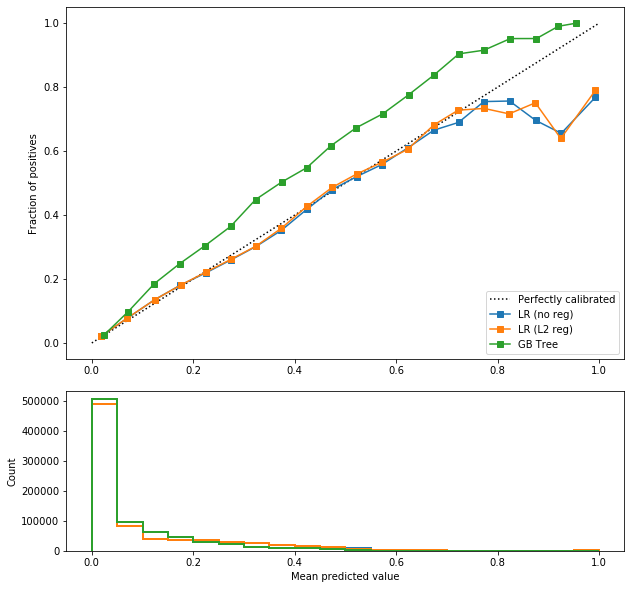

In [191]:
fig = plt.figure(0, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for label, tup in zip(['LR (no reg)', 'LR (L2 reg)', 'GB Tree'], clf_results):
    y_pred_test, y_pred_test_proba, y_test = tup
    frac_of_pos, mean_pred_value = sklearn.calibration.calibration_curve(y_test, y_pred_test_proba, n_bins=20)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=label)
    ax1.set_ylabel("Fraction of positives")
    ax2.hist(y_pred_test_proba, range=(0, 1), bins=20, histtype="step", lw=2, log=False)
    
    acc_test = np.sum(y_pred_test == y_test) / len(y_pred_test)
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test_proba)
    print(f"{label}; accuracy: {acc_test*100:.3f}%; test ROC AUC: {roc_auc:.4f}; % reverted; {np.sum(y_pred_test) / len(y_test)}")
    print(sklearn.metrics.classification_report(y_test, y_pred_test))
    print()
    
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")

plt.show()

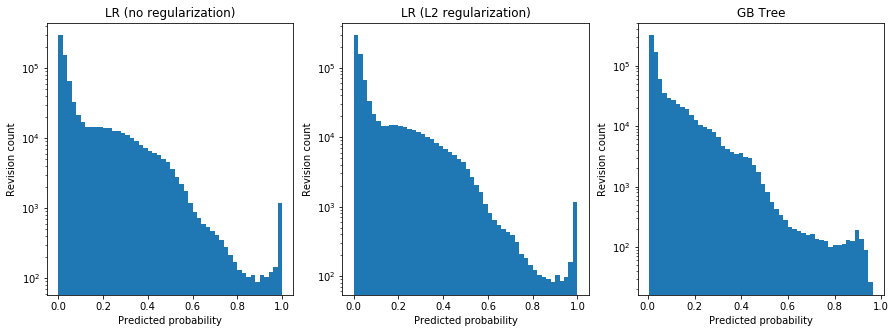

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax_title_tup in enumerate(zip(axes, ['LR (no regularization)', 'LR (L2 regularization)', 'GB Tree'])):    
    ax, title = ax_title_tup
    ax.hist(clf_results[i][1], bins=50, log=True)
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Revision count")
    ax.set_title(title)
plt.show()

In [173]:
# Check logistic regression model assumptions
# Hosmer-Lemeshow goodness of fit test
# https://jbhender.github.io/Stats506/F18/GP/Group13.html
from scipy.stats import chi2, norm
def hl_test(pred_prob, label, g):
    '''
    Hosmer-Lemeshow test to judge the goodness of fit for binary data

    Input: dataframe(data), integer(num of subgroups divided)
    
    Output: float
    '''
    data = pd.concat([pd.Series(pred_prob).rename('pred_prob'), label.rename('label')], axis = 1)
    data_st = data.sort_values('pred_prob')
    data_st['dcl'] = pd.cut(data_st['pred_prob'], g)
    
    ys = data_st['label'].groupby(data_st.dcl).sum()
    #count() gives count of non-NA cells
    yt = data_st['label'].groupby(data_st.dcl).count()
    yn = yt - ys
    print('Observed y=1')
    print(ys)
    print('Observed Total')
    print(yt)
    print('Total "True" labels: {}'.format(ys.sum()))
    print('Total "False" labels: {}'.format(yn.sum()))
    print('Total observations: {}'.format(yt.sum()))
    
    yps = data_st['pred_prob'].groupby(data_st.dcl).sum()
    ypt = data_st['pred_prob'].groupby(data_st.dcl).count()
    ypn = ypt - yps
    
    hltest_list = ( ((ys - yps)**2 / yps) + ((yn - ypn)**2 / ypn) )
    #print('Group HL test statistic')
    #print(hltest_list)
    hltest = hltest_list.sum()
    pval = 1 - chi2.cdf(hltest, g-2)
    
    df = g-2
    
    print('\n HL-chi2({}): {}, p-value: {}\n'.format(df, hltest, pval))

Here is the puzzle. I am relatively sure this is some small Python error due to my being rusty, but can't pin it down.

The H-L test function removes "NA" labels, which is why the overall totals in cell 223 are lower than those in cell 222.

But why are the total counts of "True" labels lower in 223 than 222? Aren't we using the same series? Is there something with the way numpy bincount works?
(`bin_true = np.bincount(binids, weights=y_test, minlength=len(bins))`) 
The only difference between the two functions seems to be that one uses pandas (H-L) and the other numpy (sklearn loop). This is where I'm probably missing something obvious.

The H-L test stats are way higher than is reasonable because there is an approximately portion of "True" labels in each bin. This is not the case in the calibration curve bins, even though they are supposedly the same bins. The share of "True" labels approaches 90% in the top calibration curve bins, but is ~10% in all H-L test bins.

In [222]:
# Replicate code used to produce the calibration curves above (sklearn calibration_curve)
# Loop prints number of "True" labels in each bin, followed by total True, total False, number of observations per bin, and total observations
for label, tup in zip(['LR (no reg)', 'LR (L2 reg)', 'GB Tree'], clf_results):
    y_pred_test, y_pred_test_proba, y_test = tup
    bins = np.linspace(0., 1. + 1e-8, 20 + 1)
    binids = np.digitize(y_pred_test_proba, bins) - 1
    bin_sums = np.bincount(binids, weights=y_pred_test_proba, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_test, minlength=len(bins))
    bin_false = np.bincount(binids, weights=1-y_test, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))
    
    print(label)
    print(bin_true)
    print('Total "True" labels: {}'.format(bin_true.sum()))
    print('Total "False" labels: {}'.format(bin_false.sum()))
    print(bin_total)
    print('Total observations: {}'.format(bin_total.sum()))

    nonzero = bin_total != 0
    avg_true = bin_true[nonzero] / bin_total[nonzero]
    avg_pred = bin_sums[nonzero] / bin_total[nonzero]

LR (no reg)
[10775.  6303.  5232.  6540.  7519.  7971.  7773.  6982.  6500.  5929.
  4006.  2234.  1172.   855.   631.   388.   230.   172.   177.  1077.
     0.]
Total "True" labels: 82466.0
Total "False" labels: 718665.0
[487707  81581  38718  36148  34306  30667  25735  19813  15538  12357
   7698   4005   1921   1285    915    514    304    247    270   1402
      0]
Total observations: 801131
LR (L2 reg)
[10692.  6336.  5234.  6664.  7754.  8063.  7870.  7181.  6647.  5830.
  3781.  2077.  1050.   798.   578.   322.   192.   172.   149.  1076.
     0.]
Total "True" labels: 82466.0
Total "False" labels: 718665.0
[487610  81470  38736  36869  35034  30832  25961  20002  15564  11986
   7157   3680   1734   1171    794    439    268    229    233   1362
      0]
Total observations: 801131
GB Tree
[1.1963e+04 9.4520e+03 1.1705e+04 1.1311e+04 8.5020e+03 8.0310e+03
 5.6070e+03 4.6680e+03 4.3420e+03 2.7500e+03 1.1920e+03 6.0600e+02
 4.1600e+02 3.6900e+02 3.3000e+02 2.7100e+02 2.7700e+02 

In [223]:
# Hosmer-Lemeshow test for each model.
# H-L test function prints number of "True" labels in each bin, followed by total in each bin and total True, total Observations
for label, tup in zip(['LR (no reg)', 'LR (L2 reg)', 'GB Tree'], clf_results):
    y_pred_test, y_pred_test_proba, y_test = tup
    print(label)
    hl_test(y_pred_test_proba, y_test, 20)


LR (no reg)
Observed y=1
dcl
(-0.001, 0.05]    9837
(0.05, 0.1]       1654
(0.1, 0.15]        796
(0.15, 0.2]        742
(0.2, 0.25]        694
(0.25, 0.3]        644
(0.3, 0.35]        544
(0.35, 0.4]        397
(0.4, 0.45]        330
(0.45, 0.5]        250
(0.5, 0.55]        173
(0.55, 0.6]         80
(0.6, 0.65]         36
(0.65, 0.7]         19
(0.7, 0.75]         23
(0.75, 0.8]          7
(0.8, 0.85]          5
(0.85, 0.9]          6
(0.9, 0.95]          4
(0.95, 1.0]         23
Name: label, dtype: int64
Observed Total
dcl
(-0.001, 0.05]    97577
(0.05, 0.1]       16399
(0.1, 0.15]        7748
(0.15, 0.2]        7262
(0.2, 0.25]        6996
(0.25, 0.3]        6163
(0.3, 0.35]        5067
(0.35, 0.4]        3957
(0.4, 0.45]        3178
(0.45, 0.5]        2471
(0.5, 0.55]        1594
(0.55, 0.6]         808
(0.6, 0.65]         358
(0.65, 0.7]         256
(0.7, 0.75]         174
(0.75, 0.8]         102
(0.8, 0.85]          71
(0.85, 0.9]          47
(0.9, 0.95]          49
(0.95, 1.0